In [6]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

### **1. Perspective Transformation**

In [7]:
def create_world_grid(pattern_shape, pattern_size_mm):
    world_grid = np.indices((pattern_shape[0], pattern_shape[1])).transpose().reshape(-1, 2)
    world_grid = np.hstack((world_grid, np.zeros((world_grid.shape[0], 1))))
    world_grid = np.multiply(world_grid, pattern_size_mm).astype(np.float32)
    return world_grid

In [8]:
image = cv.imread("./assets/IMG_20241019_160956.jpg")
camera_matrix = np.loadtxt("./assets/huawei_camera_matrix.txt")
dist_coefs = np.loadtxt("./assets/huawei_dist_coeffs.txt")

PATTERN_SHAPE = (10, 7)  # Inner corners.
PATTERN_SIZE_MM = 25  # Size of the squares in mm.

CORNER_SUB_PIX_CRITERIA = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
CHESSBOARD_CORNERS_FLAGS = cv.CALIB_CB_ADAPTIVE_THRESH | cv.CALIB_CB_NORMALIZE_IMAGE

image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
image = cv.undistort(image, camera_matrix, dist_coefs)

found, corners = cv.findChessboardCorners(image, PATTERN_SHAPE, None, CHESSBOARD_CORNERS_FLAGS)
corners = cv.cornerSubPix(image, corners, (11, 11), (-1, -1), CORNER_SUB_PIX_CRITERIA)

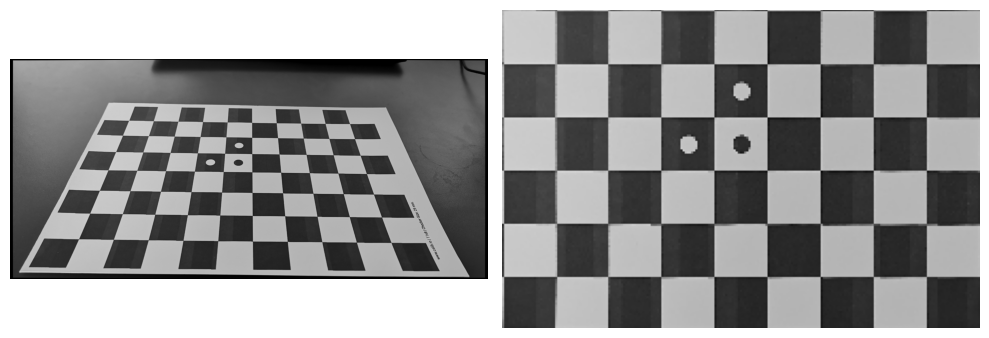

In [9]:
world_grid = create_world_grid(PATTERN_SHAPE, PATTERN_SIZE_MM)

max_right = (PATTERN_SHAPE[0] - 1) * PATTERN_SIZE_MM
max_bottom = (PATTERN_SHAPE[1] - 1) * PATTERN_SIZE_MM

tl = np.all(world_grid == [0, 0, 0], axis=1)
tr = np.all(world_grid == [max_right, 0, 0], axis=1)
bl = np.all(world_grid == [0, max_bottom, 0], axis=1)
br = np.all(world_grid == [max_right, max_bottom, 0], axis=1)

# getPerspectiveTransform requires four pairs of corresponding points.
world_points = world_grid[tl | tr | bl | br, :2]
image_points = corners[tl | tr | bl | br]

worlds_points = world_points.reshape(-1, 1, 2)
image_points = image_points.reshape(-1, 1, 2)

M = cv.getPerspectiveTransform(image_points[::-1], world_points)
warped = cv.warpPerspective(image, M, (max_right, max_bottom))

plt.figure(figsize=(10, 5), tight_layout=True)
plt.subplot(1, 2, 1)
plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(cv.cvtColor(warped, cv.COLOR_BGR2RGB))
plt.axis("off")
plt.show()